In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sci
from scipy.integrate import simps

from FEM_setup import fem_solver, make_partition,Psi_0,Psi_1,Psi_2,map_to_element_k
from Solve_optimal_controll import solve_optimal_control_1d

In [2]:
###helper functions
def make_elements(N):
    """
    Returns a list of elements where each element is represented by its three nodal coordinates.
    For element j (j=0,...,N-1), the nodes are [x[2*j], x[2*j+1], x[2*j+2]].
    """
    x_nodes, _ = make_partition(N)
    Elements = []
    for j in range(N):
        Elements.append([x_nodes[2*j], x_nodes[2*j+1], x_nodes[2*j+2]])
    return Elements


def solve_poisson_full(f, N):
    # Reconstruct full solution with u(0)=u(1)=0.
    u_interior = fem_solver(f, N, dirichlet=True)
    u_full = np.zeros(2 * N + 1)
    u_full[1:-1] = u_interior
    return u_full

def extend_solution(u_interior, nodes, boundary_value=0.0):
    """
    Extend the interior solution u_interior (length len(nodes)-2) to a full solution
    including boundary nodes.
    """
    u_full = np.zeros(len(nodes))
    u_full[1:-1] = u_interior
    # Optionally set u_full[0] and u_full[-1] to boundary_value if not zero
    return u_full

def grad_psi_0(x):
    return 4*x - 3
def grad_psi_1(x):
    return 4-8*x
def grad_psi_2(x):
    return 4*x-1


def interpolator(x, Elements, u_fem):
    ''' 
    Interpolate the FEM solution at given physical points using the shape functions.
    
    Parameters:
      x: numpy array of points in [0,1] where u_h should be evaluated.
      Elements: list of elements, each given as [x0, x1, x2] (the nodal coordinates).
      u_fem: numpy array of FEM coefficients (length 2*N+1).
    
    Returns:
      u_interp: numpy array of interpolated solution values.
    '''
    u_interp = np.zeros_like(x)
    for i in range(len(x)):
        # Loop over elements until we find one containing x[i].
        for j, K in enumerate(Elements):
            if (K[0] <= x[i]) and (x[i] <= K[2]):
                x0, x2 = K[0], K[2]
                h = x2 - x0
                # Use element j’s coefficients.
                relevant_vals = u_fem[2 * j : 2 * j + 3]
                # Map physical x to reference coordinate xi in [0,1]:
                xi = (x[i] - x0) / h
                u_interp[i] = (relevant_vals[0] * Psi_0(xi) +
                               relevant_vals[1] * Psi_1(xi) +
                               relevant_vals[2] * Psi_2(xi))
                break  # Once the correct element is found, move to the next x[i].
    return u_interp


def interpolator_derivative(x, Elements, u_fem):
    '''
    Interpolate the derivative of the FEM solution at given physical points.
    
    input:
      x: numpy array of points in [0,1] where the derivative is evaluated.
      Elements: list of elements, each given as [x0, x1, x2].
      u_fem: numpy array of FEM coefficients (length 2*N+1).
    
    Returns:
      u_interp_deriv: numpy array of derivative values.
    '''
    u_interp_deriv = np.zeros_like(x)
    for i in range(len(x)):
        for j, K in enumerate(Elements):
            if (K[0] <= x[i]) and (x[i] <= K[2]):
                x0, x2 = K[0], K[2]
                h = x2 - x0
                relevant_vals = u_fem[2 * j : 2 * j + 3]
                xi = (x[i] - x0) / h
               
                u_interp_deriv[i] = (relevant_vals[0] * grad_psi_0(xi) +
                                     relevant_vals[1] * grad_psi_1(xi) +
                                     relevant_vals[2] * grad_psi_2(xi))*1/h
                break
    return u_interp_deriv




/var/folders/fl/jgxksg290b10rvg0xtz_qtrr0000gn/T/ipykernel_64935/274194876.py:18: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  error_sq = simps((u_exact_vals - u_interp_vals) ** 2, x_dense)


N =  10 elements, h =  0.10000, error =  8.06204e-05
N =  20 elements, h =  0.05000, error =  1.00176e-05
N =  40 elements, h =  0.02500, error =  1.25033e-06
N =  80 elements, h =  0.01250, error =  1.56235e-07
Empirical rate between N=10 and N=20: 3.009
Empirical rate between N=20 and N=40: 3.002
Empirical rate between N=40 and N=80: 3.001
Estimated overall convergence order: 3.004


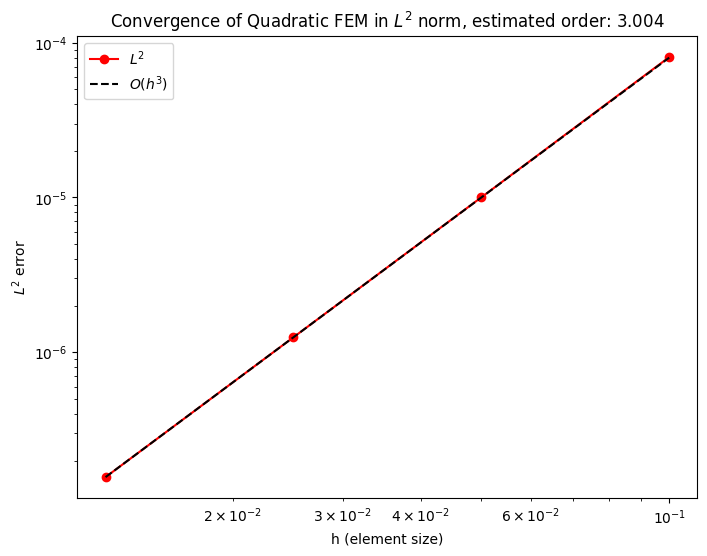

/var/folders/fl/jgxksg290b10rvg0xtz_qtrr0000gn/T/ipykernel_64935/274194876.py:47: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  L2_err_sq = simps((u_exact_vals - u_interp_vals) ** 2, x_dense)
/var/folders/fl/jgxksg290b10rvg0xtz_qtrr0000gn/T/ipykernel_64935/274194876.py:48: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  deriv_err_sq = simps((u_exact_deriv - u_interp_deriv) ** 2, x_dense)


N =  10 elements, h =  0.10000, error =  5.17648e-03
N =  20 elements, h =  0.05000, error =  1.29547e-03
N =  40 elements, h =  0.02500, error =  3.23574e-04
N =  80 elements, h =  0.01250, error =  8.09872e-05
N = 100 elements, h =  0.01000, error =  5.18152e-05
N = 500 elements, h =  0.00200, error =  1.86477e-06
N = 1000 elements, h =  0.00100, error =  5.51784e-07
N = 2000 elements, h =  0.00050, error =  1.37889e-07
Empirical rate between N=10 and N=20: 1.998
Empirical rate between N=20 and N=40: 2.001
Empirical rate between N=40 and N=80: 1.998
Empirical rate between N=80 and N=100: 2.001
Empirical rate between N=100 and N=500: 2.066
Empirical rate between N=500 and N=1000: 1.757
Empirical rate between N=1000 and N=2000: 2.001
Estimated overall convergence order: 1.994


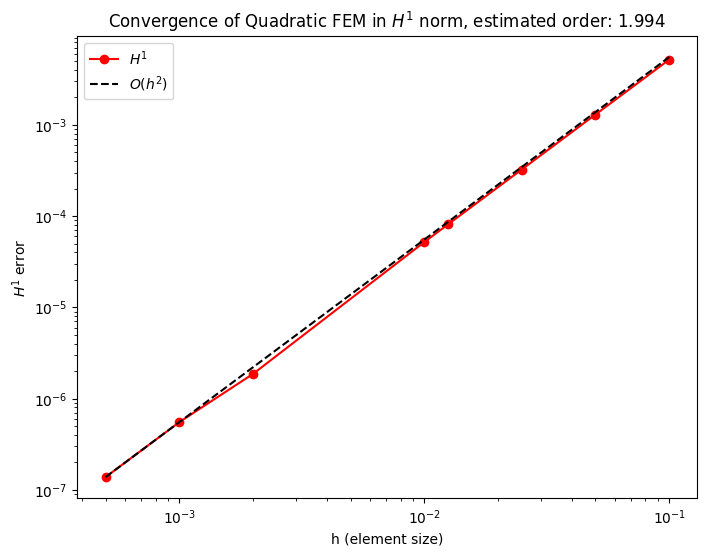

In [3]:

def L2_error(u_exact, u_fem, Elements, num_points=1000):
    """
    Computes the L2 error between the exact solution u_exact and the FEM solution u_fem.
    The FEM solution is interpolated on a dense grid using the helper function.
    
    Parameters:
      u_exact: callable, exact solution function.
      u_fem: numpy array of FEM coefficients.
      Elements: list of elements.
      num_points: number of points to use in the dense integration.
    
    Returns:
      L2 error (float)
    """
    x_dense = np.linspace(0, 1, num_points)
    u_exact_vals = u_exact(x_dense)
    u_interp_vals = interpolator(x_dense, Elements, u_fem)
    error_sq = simps((u_exact_vals - u_interp_vals) ** 2, x_dense)
    return np.sqrt(error_sq)

def H1_error(u_exact, grad_u_exact, u_fem, Elements, num_points=1000):
    """
    Computes the H1 error between the exact solution and the FEM solution.

    Here, u_h and its derivative are obtained via interpolation.
    
    input:
      u_exact: callable, exact solution.
      grad_u_exact: callable, derivative of the exact solution.
      u_fem: numpy array of FEM coefficients.
      Elements: list of elements.
      num_points: number of points in the dense grid for integration.
    
    Returns:
      H1 error (float)
    """
    x_dense = np.linspace(0, 1, num_points)
    
    # Evaluate the exact and FEM-interpolated solutions.
    u_exact_vals = u_exact(x_dense)
    u_interp_vals = interpolator(x_dense, Elements, u_fem)
    
    # Evaluate the exact and FEM-interpolated derivatives.
    u_exact_deriv = grad_u_exact(x_dense)
    u_interp_deriv = interpolator_derivative(x_dense, Elements, u_fem)
    
    L2_err_sq = simps((u_exact_vals - u_interp_vals) ** 2, x_dense)
    deriv_err_sq = simps((u_exact_deriv - u_interp_deriv) ** 2, x_dense)
    
    return np.sqrt(L2_err_sq + deriv_err_sq)


def convergence_plotter(Ns, error_function, u_exact, source_function, grad_exact=None, label=''):
    ''' 
    Plot a convergence curve for a given error norm.
    
    Parameters:
      Ns: list of numbers of elements to use.
      error_function: function to compute the error norm. It should have one of the forms:
                         L2_error(u_exact, u_fem, Elements, num_points=...)
                         H1_error(u_exact, grad_exact, u_fem, Elements, num_points=...)
      u_exact:callable, the exact solution.
      source_function:callable, the source function f (used in the FEM solver).
      grad_exact:callable, the gradient of the exact solution (if computing H1 error).
        If None, then L2 error is assumed.
      label: string, used in the plot (e.g. '$L^2$' or '$H^1$').
    '''
    errors = []
    hs = []
    for N in Ns:
        # Solve the Poisson problem
        u_fem = solve_poisson_full(source_function, N)
        # Build element connectivity for the quadratic FEM
        Elements = make_elements(N)
        # Compute the error (depending on whether grad_exact is provided)
        if grad_exact is None:
            err = error_function(u_exact, u_fem, Elements, num_points=1000)
            expected_slope  = 3
        else:
            err = error_function(u_exact, grad_exact, u_fem, Elements, num_points=1000)
            expected_slope = 2
        errors.append(err)
        hs.append(1.0 / N)
        print(f"N = {N:3d} elements, h = {1.0/N:8.5f}, error = {err:12.5e}")
    
    # Compute empirical convergence rates between successive refinements.
    for i in range(1, len(errors)):
        rate = np.log(errors[i] / errors[i-1]) / np.log(hs[i] / hs[i-1])
        print(f"Empirical rate between N={Ns[i-1]} and N={Ns[i]}: {rate:5.3f}")
    
    # Fit a line to the log-log data to estimate the overall convergence order.
    p, _ = np.polyfit(np.log(hs), np.log(errors), 1)
    print(f"Estimated overall convergence order: {p:5.3f}")
    
    # Plot convergence: log-log plot of h vs error.
    plt.figure(figsize=(8, 6))
    plt.loglog(hs, errors, 'ro-', label=label)
    
    # Plot a reference line with expected slope.
    # For example, if you expect O(h^3) convergence, do:
   
    h_ref = np.linspace(min(hs), max(hs), 100)
    # Choose the constant so that the reference line goes through the last data point.
    C_ref = errors[-1] / (hs[-1]**expected_slope)
    plt.loglog(h_ref, C_ref * h_ref**expected_slope, 'k--', label=f'$O(h^{expected_slope})$')
    
    plt.xlabel('h (element size)')
    plt.ylabel(f'{label} error')
    plt.title(f'Convergence of Quadratic FEM in {label} norm, estimated order: {p:5.3f}')
    plt.legend()
    plt.show()

def f_test(x):
    return np.pi**2 * np.sin(np.pi*x) # 2.0
def u_exact(x):
    
    return np.sin(np.pi*x)
 
def grad_u_exct(x):
    return np.pi*np.cos(np.pi*x)

def f1(x):
    '''source function f(x) = 1'''
    return np.ones_like(x)
def exact1(x):
    return 1/2*x*(1-x)
def grad_exact1(x):
    return 1/2-x

def f2(x):
    return -np.exp(-x)*(np.sin(np.pi*x)*(1-np.pi**2) - 2*np.pi*np.cos(np.pi*x))
    
def exact2(x):
    return np.exp(-x)*(np.sin(np.pi*x))
def grad_exact2(x):
    return np.exp(-x)*(-np.sin(np.pi*x) + np.pi*np.cos(np.pi *x))


convergence_plotter(Ns=[10, 20, 40, 80], error_function=L2_error, u_exact=exact2, source_function=f2, grad_exact=None, 
                    label='$L^2$')

# For H1 error:
convergence_plotter(Ns=[10, 20, 40, 80, 100, 500, 1000, 2000],error_function=H1_error, u_exact=exact2, source_function=f2, 
                    grad_exact=grad_exact2, 
                    label='$H^1$')



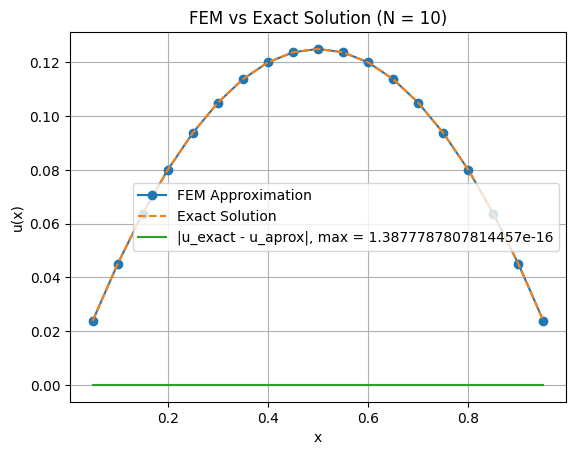

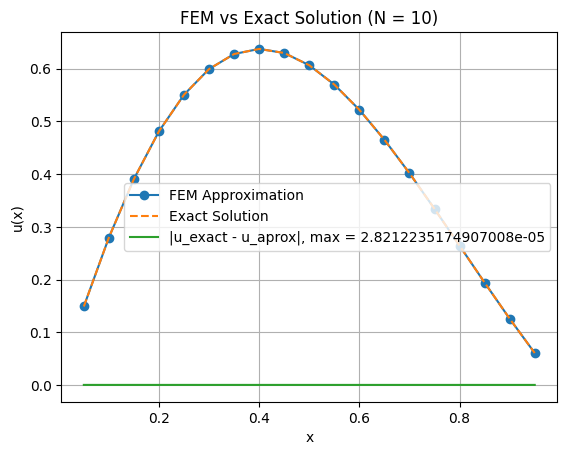

In [4]:
def plot_FEM_and_exact(u_aprox, u_exact, N, direchlet=True):
    '''
    Plots the approximated FEM solution against the exact solution.
    Plots absolute error and shows max norm of errors

    input:
    - u_aprox: solution from FEM (assumed to be full vector of length 2N+1)
    - u_exact: callable exact solution u(x)
    - N: number of elements
    '''

    x_nodes = np.linspace(0, 1, 2*N + 1)  # FEM global nodes (where u_aprox is defined)
    # print(x_nodes, x_nodes[1:-1])
    exact_values = u_exact(x_nodes) 
    # print(exact_values.shape)
    if direchlet:
        x_nodes = x_nodes[1:-1]
    exact_values = u_exact(x_nodes)   # Evaluate exact solution at same points
    # print(exact_values.shape)
    errors = np.abs(exact_values - u_aprox)
    
    plt.plot(x_nodes, u_aprox, 'o-', label='FEM Approximation')
    plt.plot(x_nodes, exact_values, '--', label='Exact Solution')
    plt.plot(x_nodes, errors, label = f'|u_exact - u_aprox|, max = {np.max(errors)}')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title(f'FEM vs Exact Solution (N = {N})')
    plt.grid(True)
    plt.legend()
    plt.show()


#tests: 
u1 = fem_solver(f1,10)
plot_FEM_and_exact(u1, exact1, 10)

u2 = fem_solver(f2, 10)
plot_FEM_and_exact(u2, exact2, 10)

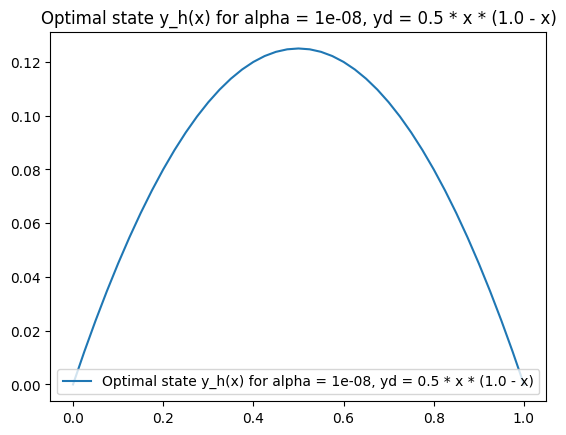

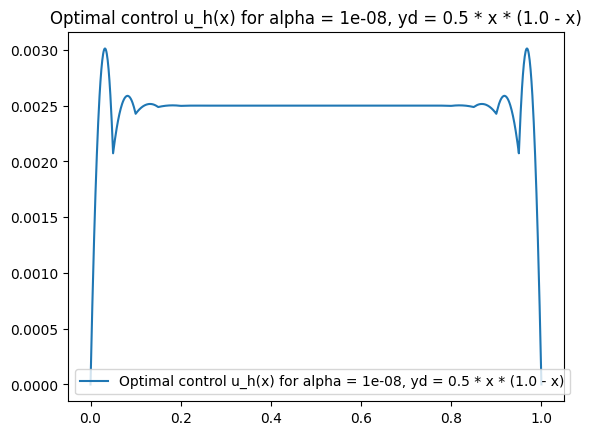

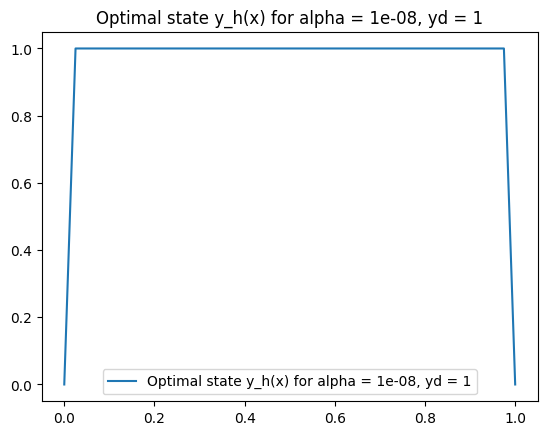

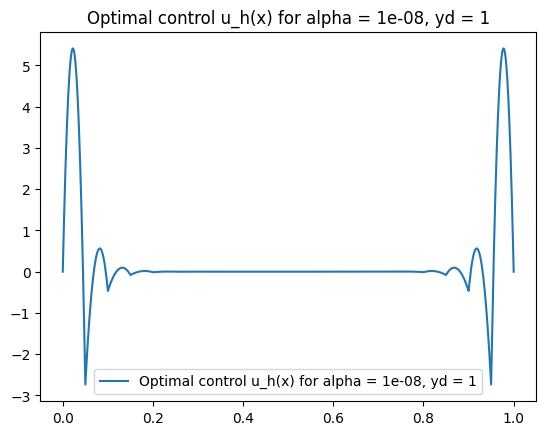

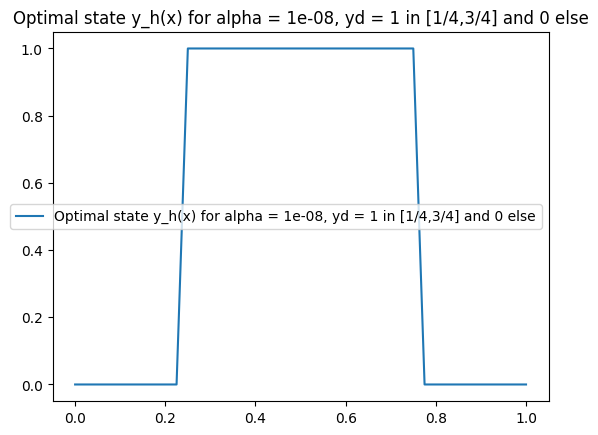

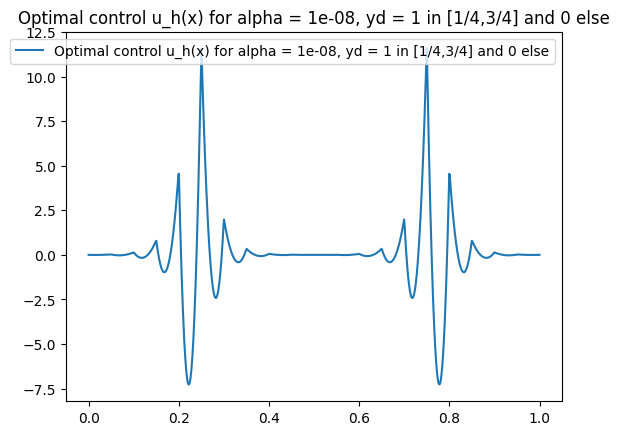

In [5]:
#### plot the solutions to the optimal controll proble, 
def plot_solution(nodes, y, label_str="y_h(x)", Elements=None):
    """
    Plot a piecewise-quadratic function y given by the interior DOFs 'y'
    on the mesh 'nodes'. If Elements is provided, use the interpolator to 
    evaluate the FEM solution at a fine grid
    """
    if Elements is not None:
        # Generate a fine grid over the domain [nodes[0], nodes[-1]]
        x_fine = np.linspace(nodes[0], nodes[-1], 1000)
        y_interp = interpolator(x_fine, Elements, y)
        plt.figure()
        plt.plot(x_fine, y_interp, label=label_str)
        plt.title(label_str)
        plt.legend()
        plt.show()
    else:
        full_sol = np.zeros(len(nodes))
        boundary0 = 0
        boundary1 = len(nodes) - 1

        idx = 0
        for j in range(len(nodes)):
            if j == boundary0 or j == boundary1:
                full_sol[j] = 0.0  # boundary condition
            else:
                full_sol[j] = y[idx]
                idx += 1

        plt.figure()
        plt.plot(nodes, full_sol, label=label_str)
        plt.title(label_str)
        plt.legend()
        plt.show()



def y_d_function(x):
   return 0.5 * x * (1.0 - x)

def y_d2_function(x):
    return np.ones_like(x)

def y_d3_function(x): 
    return np.where((x >= 1/4) & (x <= 3/4), 1, 0)

num_elems = 20    
alpha = 1e-8      


nodes, y_sol, u_sol, lam_sol = solve_optimal_control_1d(y_d_function, num_elems, alpha)
u_full = extend_solution(u_sol, nodes)

plot_solution(nodes, y_sol, label_str=(f"Optimal state y_h(x) for alpha = {alpha}, yd = 0.5 * x * (1.0 - x)"))

Elements = []
for j in range(num_elems):
    Elements.append([nodes[2*j], nodes[2*j+1], nodes[2*j+2]])

plot_solution(nodes, u_full, label_str=(f"Optimal control u_h(x) for alpha = {alpha}, yd = 0.5 * x * (1.0 - x)"), Elements=Elements)


nodes, y_sol2, u_sol2, lam_sol2 = solve_optimal_control_1d(y_d2_function, num_elems, alpha)
u_full2 = extend_solution(u_sol2, nodes)
plot_solution(nodes, y_sol2, label_str=(f"Optimal state y_h(x) for alpha = {alpha}, yd = 1"))
plot_solution(nodes, u_full2, label_str=(f"Optimal control u_h(x) for alpha = {alpha}, yd = 1"), Elements=Elements)

nodes, y_sol3, u_sol3, lam_sol3 = solve_optimal_control_1d(y_d3_function, num_elems, alpha)
u_full3 = extend_solution(u_sol3, nodes)
plot_solution(nodes, y_sol3, label_str=(f"Optimal state y_h(x) for alpha = {alpha}, yd = 1 in [1/4,3/4] and 0 else"))
plot_solution(nodes, u_full3, label_str=(f"Optimal control u_h(x) for alpha = {alpha}, yd = 1 in [1/4,3/4] and 0 else"), Elements=Elements)

